Nous allons utiliser l'algorithme node2vec pour représenter le graph des relations deezer de la Roumanie différemment. Nous utiliserons ensuite des méthodes de clustering pour effectuer de  la détection de communauté et pouvoir les comparer aux méthodes traditionnelles sans Machine learning. 

In [18]:
import networkx as nx
import pandas as pd
from pyvis.network import Network
from node2vec import Node2Vec
import random
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
# Read the CSV file
df = pd.read_csv('deezer_clean_data/HR_edges.csv')

# Create a graph
G = nx.from_pandas_edgelist(df, source='node_1', target='node_2')

# Get a sample of 10,000 nodes from G
random.seed(42)
sample_nodes = random.sample(list(G.nodes()), 10000)

# Create a new graph with the sample nodes
G = G.subgraph(sample_nodes)

# Print the graph summary
print(G)

Graph with 10000 nodes and 16022 edges


In [31]:

# Initialisation de Node2Vec avec les hyperparamètres du papier original 
#Après quelques tentatives on s'est rendu compte que c'était les meilleurs 
node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4) 
    
# Generate walks
walks = node2vec.walks

# Train Node2Vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 10000/10000 [00:05<00:00, 1769.04it/s]


In [32]:
model.wv.save_word2vec_format("HR_embeddings.emb")

Les embeddings sont enregistrés sur un subplot de 10000 noeuds donc pas besoin de refaire tourner le fit. 

In [33]:
embeddings = KeyedVectors.load_word2vec_format("HR_embeddings.emb")
embeddings_list = np.array(list(embeddings.vectors))

In [34]:
#Une fonction pour afficher les représentation en dimensions réduites

def plot_scatter(embeddings, labels, title):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

#On représente les embeddings en 2D

n_components = 2

C:\Users\arnoh\AppData\Local\Temp\ipykernel_65824\2077088269.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)


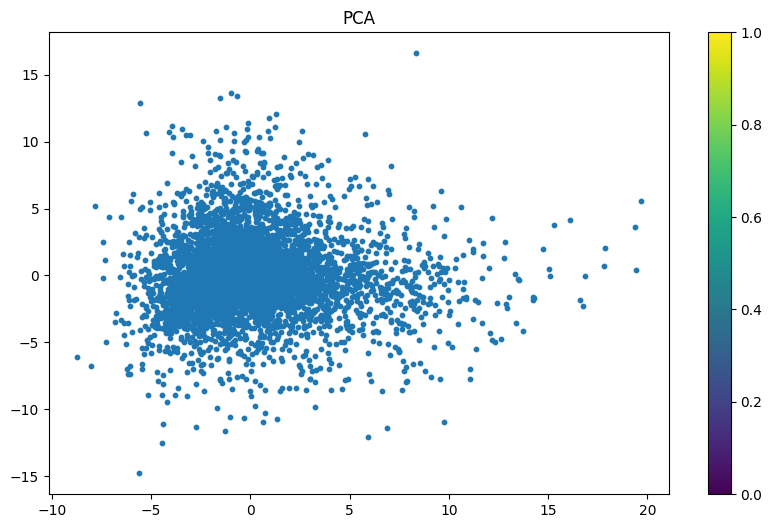

In [35]:
#On fait tourner la PCA

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embeddings_list)

#On affiche les embeddings en 2D

plot_scatter(pca_result, labels=None, title='PCA')



La PCA ne nous permet pas de visualiser grand chose en l'état, probablement que les deux dimensions sur 64 ne sont pas suffisantes pour capturer les réelles sources de variance des données. 

C:\Users\arnoh\AppData\Local\Temp\ipykernel_65824\2077088269.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)


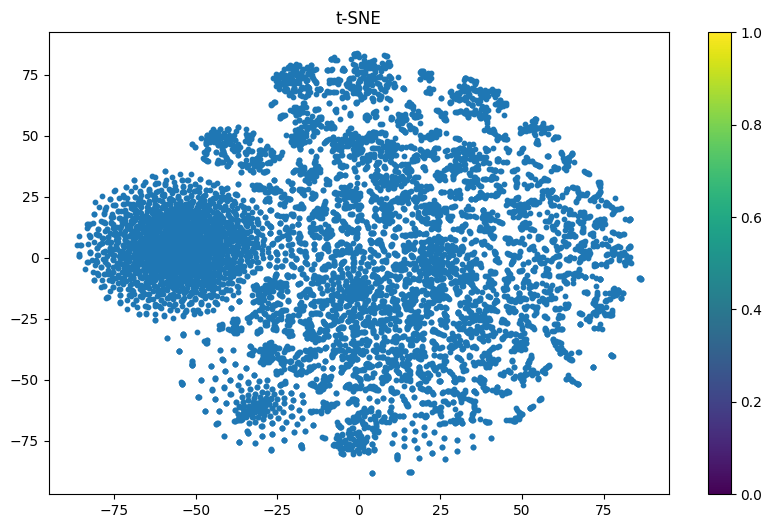

In [36]:
#We compute the t-SNE representation of the embeddings

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(embeddings_list)

#We plot the t-SNE representation of the embeddings

plot_scatter(tsne_result, labels=None, title='t-SNE')

On perçoit ce qui pourrait s'apparenter à des cluster dans cette représentation. Essayons maintenant d'en trouver dans la représentation générée par node2vec. 

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score

# Define the range of cluster numbers to try
min_clusters = 10
max_clusters = 20

# Initialize variables to store the best cluster number and silhouette score
best_cluster_number = 0
best_silhouette_score = -1

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters+1):
    # Perform clustering using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_list)
    print(cluster_labels)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(embeddings_list, cluster_labels)

    print("Number of clusters:", n_clusters, "\tSilhouette score:", silhouette_avg)
    
    # Check if the current silhouette score is better than the previous best score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_cluster_number = n_clusters

    

# Print the optimal cluster number and silhouette score
print("Optimal number of clusters:", best_cluster_number)
print("Silhouette score:", best_silhouette_score)

#Best silhouette score so far for two clusters : 0,34


Highest silhouette score for n_clusters = 2. But interesting score at 15 clusters : 0,22 which is higher than many other scores before. 

In [52]:
#A function to create partition with clusters

def create_modularity_partition(G, clusters):
    """
    Create a partition for a graph using clustering results.
    
    Parameters:
        - G: NetworkX graph
        - clusters: List of cluster assignments
    
    Returns:
        - partition: Dictionary mapping nodes to their respective communities
    """
    partition = {}
    for node, cluster_id in enumerate(clusters, start=1):
        partition[G.nodes[node]] = cluster_id
    return partition

In [53]:
# Define the range of cluster numbers to try
min_clusters = 2
max_clusters = 20

# Initialize variables to store the best cluster number and modularity score
best_cluster_number = 0
best_modularity_score = -1

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters+1):
    # Perform clustering using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_list)
    
    # Calculate the modularity score
    modularity = nx.algorithms.community.modularity(G, create_modularity_partition(G, cluster_labels))

    print("Number of clusters:", n_clusters, "\tModularity score:", modularity)
    
    # Check if the current modularity score is better than the previous best score
    if modularity > best_modularity_score:
        best_modularity_score = modularity
        best_cluster_number = n_clusters

# Print the optimal cluster number and modularity score
print("Optimal number of clusters:", best_cluster_number)
print("Modularity score:", best_modularity_score)


c:\Users\arnoh\anaconda3\envs\con_rais\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyError: 'Key 1 not found'

In [30]:
#Let's see if we can do something better with DBSCAN
#We will try make a grid search on eps and min_samples

# Define the range of eps values to try

eps_values = [0.1, 0.5, 1, 2, 5, 10]

# Define the range of min_samples values to try

min_samples_values = [5, 10, 20, 50]

#We evaluate the quality of the hyperparameters using the silhouette score

best_silhouette_score = -1

# Initialize variables to store the best hyperparameters

best_eps = 0
best_min_samples = 0

# Iterate over the range of eps values

for eps in eps_values:
    # Iterate over the range of min_samples values
    for min_samples in min_samples_values:
        # Perform clustering using DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(embeddings_list)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(embeddings_list, cluster_labels)

        print("eps:", eps, "min_samples:", min_samples, "silhouette score:", silhouette_avg)
        
        # Check if the current silhouette score is better than the previous best score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples

# Print the optimal hyperparameters and silhouette score
print("Optimal eps:", best_eps)
print("Optimal min_samples:", best_min_samples)
print("Silhouette score:", best_silhouette_score)

eps: 0.1 min_samples: 5 silhouette score: -0.06464546
eps: 0.1 min_samples: 10 silhouette score: -0.06464546
eps: 0.1 min_samples: 20 silhouette score: -0.06464546
eps: 0.1 min_samples: 50 silhouette score: -0.06464546
eps: 0.5 min_samples: 5 silhouette score: -0.06464546
eps: 0.5 min_samples: 10 silhouette score: -0.06464546
eps: 0.5 min_samples: 20 silhouette score: -0.06464546
eps: 0.5 min_samples: 50 silhouette score: -0.06464546


KeyboardInterrupt: 